## Time to get your hands dirty.  The transient Universe
**Remember this is a real research example, not an exam! You're welcome (and encouraged actually!) to use all the tutorials/answers/hack you find online!**


1) Read in `solutions/transient.npy`. This is a (100 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$ (careful: uniform in $\ln\alpha$, not $\alpha$).

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 



In [523]:
import numpy as np
from matplotlib import pyplot as plt
import emcee
from scipy.stats import uniform
from scipy.optimize import curve_fit
import corner
from IPython.display import display, Math

dati = np.load('C:/Users/hp/.spyder-py3/astrostatistics_bicocca_2024/solutions/transient.npy')

In [357]:
#using where allows me to use arrays
def burst_model(x, A, b, alpha, t_0):
    y = np.where(x < t_0, b, b+A*np.exp(-alpha*(x-t_0)))
    return y

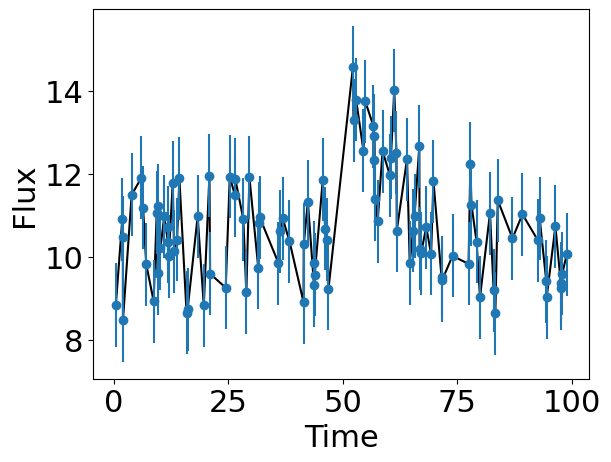

In [358]:
#plotting datas
time, flux, error = dati[:, 0], dati[:, 1], dati[:,2]
plt.plot(dati[:, 0], dati[:, 1], color = 'black')
plt.errorbar(dati[:,0], dati[:,1], yerr = dati[:,2], fmt = 'o')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.show()

In [359]:
#avoiding maximum likelihood because I don't know how to do it with four parameters
my_guesses = [10.0, 10.0, np.exp(-1), 50.0]
parameters, covariance = curve_fit(burst_model, time, flux, p0 = my_guesses)
print('Initial guess for A: ', parameters[0])
print('Initial guess for b: ', parameters[1])
print('Initial guess for alpha: ', parameters[2])
print('Initial guess for t_0: ', parameters[3])

Initial guess for A:  4.9612257094609005
Initial guess for b:  10.287881211089104
Initial guess for alpha:  0.1189072148096274
Initial guess for t_0:  49.94497532121225


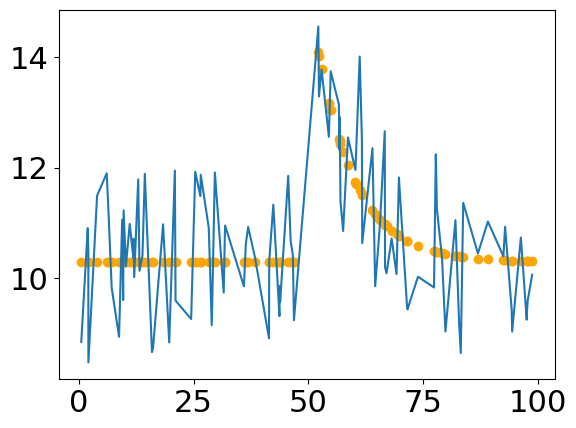

In [360]:
#check if guesses from curve_fit work well
first_fit = burst_model(time, parameters[0], parameters[1], parameters[2], parameters[3])
plt.scatter(time, first_fit, color = 'orange')
plt.plot(time, flux)

In [346]:
#limits of each parameter, suggested by exercise
A_min, A_max = 0.0, 50.0
b_min, b_max = 0.0, 50.0
alpha_min, alpha_max = np.exp(-5), np.exp(5)
#logalpha -5,5
t_0_min, t_0_max = 0.0, 100.0

#burst_model function corrected for emcee
def burst(theta,t):
    A, b, alpha, t_0 = theta 
    return np.where(t < t_0, b, b+A*np.exp(-alpha*(t-t_0)))

#log-prior as described by emcee
def log_prior(theta):
    A, b, alpha, t_0 = theta
    if A_min < A < A_max and b_min < b < b_max and alpha_min < alpha < alpha_max:
        return 0.0 +0.0 +0.0 -np.log(alpha) #ln(alpha) is 1, not alpha (the others are ln(1), this is ln(exp(alpha)) if I understood correctly)
    return -np.inf

#log likelihood as described by emcee
def log_likelihood(theta, x, y, yerr):
    A, b, logalpha, t_0 = theta
    #alpha= exp logalpha
    model = burst(theta, x)
    #sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)   ask professor, now I just use yerr
    return -0.5 * np.sum((y - model) ** 2 / yerr**2 + np.log(yerr**2))

#log probability as described by emcee
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return - np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [364]:
nwalkers, ndim = 10, 4 #number of walkers and dimensions
burn, nsteps = 100, 10000 #step needed to burn, and total number of steps

np.random.seed(9)
starting_guesses = parameters + np.random.random((nwalkers, ndim)) #walkers starting from good points, otherwise error
#initializing emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(time, flux, error))
sampler.run_mcmc(starting_guesses, nsteps)
emcee_trace = sampler.chain[:, burn:, :].reshape(-1, ndim) #getting emcee_trace

In [363]:
#check on chain/trace
print(sampler.chain.shape)
print(emcee_trace.shape)

(10, 10000, 4)
(99000, 4)


In [365]:
#check that number of steps are enough higher than the needed burning steps
tau = max(sampler.get_autocorr_time())
print(tau)
thin = int(tau+1)

98.54463636489223


In [371]:
#deleting burning phase, thinning i don't remember what does
emcee_trace = sampler.get_chain(discard = burn, thin = thin, flat = True).flatten()
len(emcee_trace)

4000

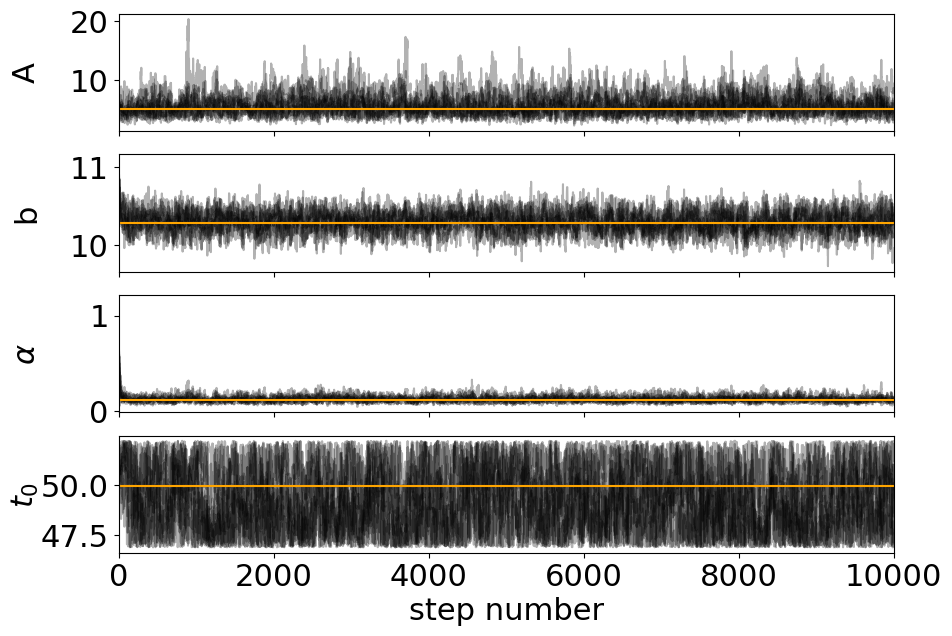

In [399]:
#plot trace as shown by emcee
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["A", "b", r"$\alpha$", r"$t_{0}$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.axhline(parameters[i], color = 'orange') #add line with initial guesses
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1].set_xlabel("step number");

In [387]:
#plotting corner plot as shown by emcee
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(6600, 4)


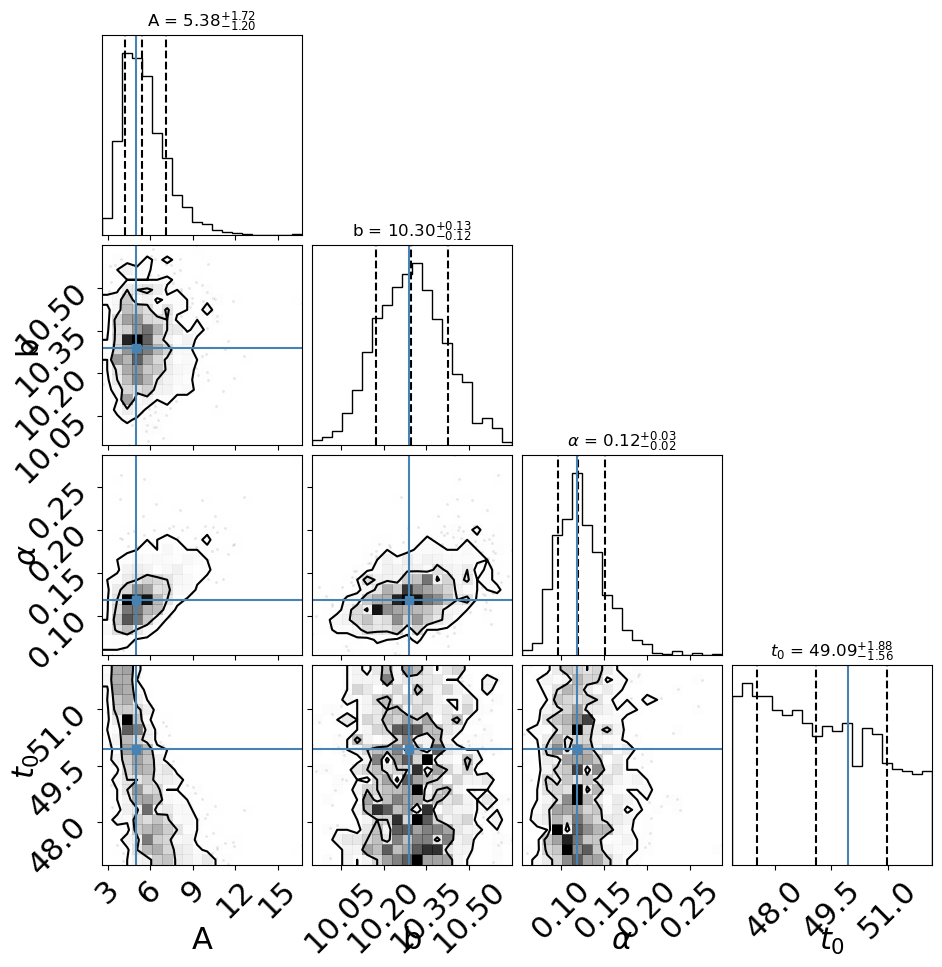

In [551]:
corner.corner(sampler.get_chain(discard = burn, thin = thin, flat = True), 
              labels = labels, truths=parameters,levels=[0.68, 0.95], 
              quantiles=[0.16, 0.5, 0.84],show_titles=True,
    title_kwargs={"fontsize": 12}); #ask how to avoid overlap of numbers/label

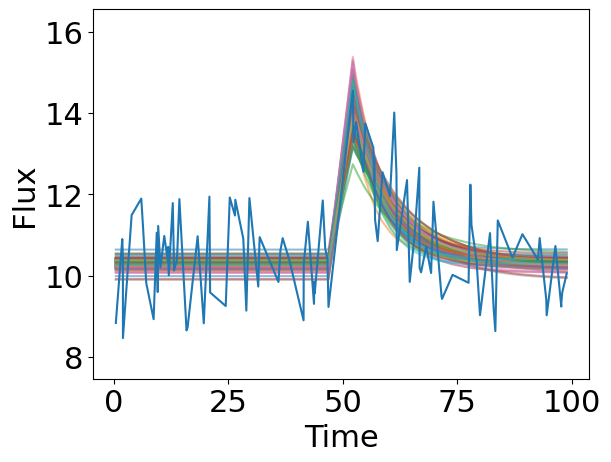

In [552]:
#choose randomly in the emcee_trace the 4 parameters
np.random.seed(777) #triple7
idx = np.random.randint(0, len(sampler.get_chain(flat = True))-1, size = 100)
for indices in idx:
    #compute for each set of parameters the resulting fit
    plt.plot(time, burst_model(time, sampler.get_chain(flat = True)[indices, 0],sampler.get_chain(flat = True)[indices, 1], sampler.get_chain(flat = True)[indices,2], sampler.get_chain(flat = True)[indices,3]), alpha = 0.5)
plt.plot(time, flux)
plt.ylim(min(flux)-1, max(flux)+2)
plt.xlabel('Time')
plt.ylabel('Flux')
plt.show()

In [556]:
#showing median +- errors considering a 90% credible region (at least I think so?)
#for loop from emcee, modified to show median as value for parameter
for i in range(ndim):
    mcmc = np.percentile(sampler.get_chain(discard=burn, thin=thin,flat = True)[:, i], [5, 50, 95])
    q = np.diff(mcmc)
    mcmc = np.median(sampler.get_chain(discard=burn, thin=thin,flat = True)[:, i])
    name = [r'$A$', r'$b$', r'$\alpha$', r'$t_0$']
    txt = name[i]+r"$ = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc, q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Note: you can't use this four together to your model because these are the median values of the marginalized distribution. What you can use is the maximum at posteriori (the array of theta that maximizes your posteriori)